*I tried to predict an emotion with LogisticRegression.*

* Dropped duplicate samples (original data size <b>839555</b>, after dropped <b>393822</b>),
* I applied several <b>preprocessing</b> operations (cleaning,dropping stop words),
* I tried a hybrid model <b>(SentenceTransformer + PCA + CatBoostClassifier)</b>, the model produce nearly 0.9 F1 score. 


<i> <b>Result: </b> <span style="color:#e74c3c;">I checked target leakage for an overfitting issue by calculating cosine similarities between train samples and test samples, but there was no considerable leakage (generally, at most cosine similarity is nearly 80-90% for only 4-5 samples). </span> </i>


## My Another Projects
* [Towards Data Science Articles Topic Modeling w/LDA](https://www.kaggle.com/code/banddaniel/towards-data-science-articles-topic-modeling-w-lda)
* [Rating Prediction w/SentenceTransformer, CatBoost](https://www.kaggle.com/code/banddaniel/rating-prediction-w-sentencetransformer-catboost)


In [1]:
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import  stopwords
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

SEED = 99

# <span style="color:#e74c3c;"> Reading </span> Data

In [2]:
data = pd.read_csv('/kaggle/input/emotion-analysis-based-on-text/emotion_sentimen_dataset.csv')
data = data.drop_duplicates(subset = ['text'], keep = 'first').reset_index(drop = True)
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data.head()

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


# <span style="color:#e74c3c;"> Preprocessing </span>

In [3]:
%%time
# preprocessing functions
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\w*xx+\w*', '', text)
    return text


def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions
data_processed = data.copy()
data_processed['preprocessed_text'] = data_processed['text'].apply(text_preprocessing).apply(drop_stopwords).apply(delete_one_characters)


# label encoding
LE = LabelEncoder()
data_processed['encoded_Emotion'] = LE.fit_transform(data_processed['Emotion'])

CPU times: user 23.2 s, sys: 62.2 ms, total: 23.3 s
Wall time: 23.3 s


In [4]:
# data after preprocessing operations
data_processed.head()

,text,Emotion,preprocessed_text,encoded_Emotion
0,i seriously hate one subject to death but now ...,hate,seriously hate one subject death feel reluctan...,6
1,im so full of life i feel appalled,neutral,im full life feel appalled,8
2,i sit here to write i start to dig out my feel...,neutral,sit write start dig feelings think afraid acce...,8
3,ive been really angry with r and i feel like a...,anger,ive really angry feel like idiot trusting fir...,0
4,i feel suspicious if there is no one outside l...,neutral,feel suspicious one outside like rapture happe...,8


In [5]:
# classes
data_processed['Emotion'].value_counts()

Emotion
neutral       316935
love           17634
happiness      13038
sadness         8485
relief          8007
hate            6160
anger           5952
fun             4854
enthusiasm      4497
surprise        3430
empty           2697
worry           2072
boredom           61
Name: count, dtype: int64

# <span style="color:#e74c3c;"> Train and Test </span> Split

In [6]:
# train and test splitting
type_train_data, type_test_data = train_test_split(data_processed, test_size = 0.15, random_state = SEED, stratify = data_processed['encoded_Emotion'])

type_train_data = type_train_data.reset_index(drop = True)
type_test_data = type_test_data.reset_index(drop = True)

y_train = type_train_data['encoded_Emotion']
y_test = type_test_data['encoded_Emotion']

print('train sample size\t', type_train_data.shape[0])
print('test sample size\t', type_test_data.shape[0])

train sample size	 334748
test sample size	 59074


# <span style="color:#e74c3c;"> LogisticRegression </span> Model

In [7]:
%%time
log_reg = make_pipeline(TfidfVectorizer(), LogisticRegression(C=2.0, max_iter = 500))
log_reg.fit(type_train_data['preprocessed_text'].values, y_train)

CPU times: user 4min 39s, sys: 3min 49s, total: 8min 28s
Wall time: 2min 38s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=2.0, max_iter=500))])

# <span style="color:#e74c3c;">Test</span> Predictions

In [8]:
# a function for calculating and plotting predictions 
def plot_prediction_results(model, X_data, y_data, target_names = list(LE.classes_)):
    pred = model.predict(X_data)
    
    mse = mean_squared_error(y_data, pred)
    f1 = f1_score(y_data, pred, average = 'weighted')
    acc = accuracy_score(y_data, pred)
    cm = confusion_matrix(y_data, pred)
    
    clf = classification_report(y_data, pred, target_names = target_names)
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay(cm, display_labels = target_names)
    fig, axs = plt.subplots(figsize=(8,8))
    cmd.plot(ax=axs, cmap = 'bone', xticks_rotation="vertical", colorbar = False)

Mean Squared Error :	0.17446
Weighted F1 Score :	0.990
Accuracy Score :	99.066 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

       anger       0.98      0.93      0.96       893
     boredom       1.00      0.22      0.36         9
       empty       1.00      0.91      0.95       404
  enthusiasm       1.00      0.96      0.98       675
         fun       0.99      0.89      0.94       728
   happiness       0.99      0.97      0.98      1956
        hate       0.99      0.96      0.97       924
        love       0.99      0.98      0.99      2645
     neutral       0.99      1.00      1.00     47541
      relief       0.98      0.93      0.95      1201
     sadness       1.00      0.97      0.98      1273
    surprise       0.99      0.95      0.97       514
       worry       1.00      0.93      0.96       311

    accuracy                           0.99     59074
   macro a

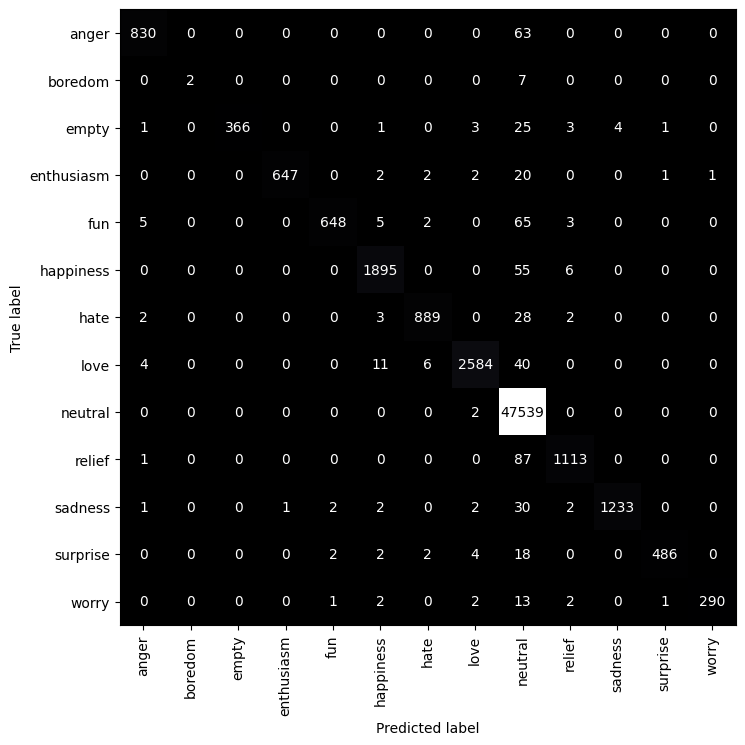

In [9]:
plot_prediction_results(log_reg, type_test_data['preprocessed_text'].values, y_test)